In [22]:
!pip -q install catboost optuna

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GroupKFold

In [2]:
TRAIN_FEAT = "train_hh_features.csv"
TRAIN_GT   = "train_hh_gt.csv"
TRAIN_RATES= "train_rates_gt.csv"
TEST_FEAT  = "test_hh_features.csv"

train_X = pd.read_csv(TRAIN_FEAT)
train_y = pd.read_csv(TRAIN_GT)
train_rates = pd.read_csv(TRAIN_RATES)
test_X  = pd.read_csv(TEST_FEAT)

df_train = train_X.merge(train_y, on=["survey_id","hhid"], how="inner")
assert len(df_train) == len(train_y)

print("Train:", train_X.shape, "Test:", test_X.shape, "Train GT:", train_y.shape, "Rates:", train_rates.shape)
df_train.head()

Train: (104234, 88) Test: (103023, 88) Train GT: (104234, 3) Rates: (3, 20)


,hhid,com,weight,strata,utl_exp_ppp17,male,hsize,num_children5,num_children10,num_children18,...,consumed4300,consumed4400,consumed4500,consumed4600,consumed4700,consumed4800,consumed4900,consumed5000,survey_id,cons_ppp17
0,100001,1,75,4,594.80627,Female,1,0,0,0,...,No,No,No,Yes,Yes,Yes,Yes,No,100000,25.258402
1,100002,1,150,4,1676.27230,Female,2,0,0,0,...,No,No,No,No,Yes,Yes,No,No,100000,16.996706
2,100003,1,375,4,506.93719,Male,5,0,0,2,...,Yes,No,Yes,Yes,Yes,Yes,No,Yes,100000,13.671848
3,100004,1,375,4,824.61786,Male,5,0,0,1,...,Yes,No,No,No,Yes,Yes,No,No,100000,7.189475
4,100005,1,525,4,351.47644,Male,7,1,0,0,...,No,No,Yes,No,Yes,Yes,Yes,No,100000,12.308855


In [3]:
THRESHOLDS = np.array([3.17,3.94,4.60,5.26,5.88,6.47,7.06,7.70,8.40,9.13,9.87,10.70,11.62,12.69,14.03,15.64,17.76,20.99,27.37])
PCTS = np.linspace(0.05, 0.95, 19)                 # ventiles -> 5%,10%,...,95%
W_T = 1 - np.abs(0.4 - PCTS)                       # w_t = 1 - |0.4 - p_t|
W_T_SUM = W_T.sum()

def poverty_rates_from_consumption(cons, weights):
    weights = weights.astype(float)
    denom = weights.sum()
    return np.array([(weights*(cons < t)).sum()/denom for t in THRESHOLDS])

def survey_metric(cons_true, cons_pred, weights, rates_true):
    cons_mape = np.mean(np.abs(cons_true - cons_pred)/cons_true)
    rates_pred = poverty_rates_from_consumption(cons_pred, weights)
    poverty_mape = np.sum(W_T * (np.abs(rates_true - rates_pred)/rates_true)) / W_T_SUM
    blended = 0.9*poverty_mape + 0.1*cons_mape
    return blended, poverty_mape, cons_mape, rates_pred


In [4]:
for sid in sorted(df_train["survey_id"].unique()):
    sub = df_train[df_train["survey_id"]==sid]
    calc = poverty_rates_from_consumption(sub["cons_ppp17"].values, sub["weight"].values)
    gt = train_rates[train_rates["survey_id"]==sid].drop(columns=["survey_id"]).values[0]
    print(sid, "max_abs_diff:", np.max(np.abs(calc-gt)))


100000 max_abs_diff: 1.1102230246251565e-16
200000 max_abs_diff: 1.1102230246251565e-16
300000 max_abs_diff: 1.1102230246251565e-16


Προεπεξεργασία categorical για CatBoost

In [5]:
X = df_train.drop(columns=["cons_ppp17"])
y = df_train["cons_ppp17"].values
groups = df_train["survey_id"].values

cat_cols = [c for c in X.columns if X[c].dtype == "object"]
num_cols = [c for c in X.columns if c not in cat_cols]

# CatBoost θέλει τα categorical ως strings και χωρίς NaN
def fix_cat(df):
    df = df.copy()
    for c in cat_cols:
        df[c] = df[c].astype("string").fillna("NA")
    return df

X_cb = fix_cat(X)
test_cb = fix_cat(test_X)

cat_idx = [X_cb.columns.get_loc(c) for c in cat_cols]

# log-transform για σταθερότητα (κατανάλωση έχει heavy tail)
y_log = np.log1p(y)


Cross-validation ανά survey

In [6]:
gkf = GroupKFold(n_splits=3)

def cv_eval(params, iterations=5000):
    rows = []
    for fold, (tr, va) in enumerate(gkf.split(X_cb, y_log, groups=groups), start=1):
        X_tr, X_va = X_cb.iloc[tr], X_cb.iloc[va]
        y_tr, y_va_log = y_log[tr], y_log[va]
        y_va = y[va]

        sid_va = X_va["survey_id"].iloc[0]
        rates_true = train_rates[train_rates["survey_id"]==sid_va].drop(columns=["survey_id"]).values[0]

        tr_pool = Pool(X_tr, y_tr, cat_features=cat_idx)
        va_pool = Pool(X_va, y_va_log, cat_features=cat_idx)

        model = CatBoostRegressor(
            loss_function="RMSE",
            eval_metric="RMSE",
            verbose=False,
            **params,
            iterations=iterations
        )
        model.fit(tr_pool, eval_set=va_pool, use_best_model=True, early_stopping_rounds=200)

        pred_va = np.expm1(model.predict(va_pool))

        sub = df_train.iloc[va]
        blended, pov, cons, _ = survey_metric(
            cons_true=y_va,
            cons_pred=pred_va,
            weights=sub["weight"].values,
            rates_true=rates_true
        )

        rows.append({
            "fold": fold,
            "val_survey": int(sid_va),
            "best_iter": model.get_best_iteration(),
            "blended": blended,
            "poverty_mape": pov,
            "cons_mape": cons
        })

    return pd.DataFrame(rows)


Fine-tuning με Optuna

In [9]:
best_params = {
    "learning_rate": 0.05,
    "depth": 8,
    "l2_leaf_reg": 10,
    "random_strength": 1.0,
    "bagging_temperature": 0.5,
    "subsample": 0.8,
    "rsm": 0.8,
    "thread_count": -1
}

print("Using manually tuned CatBoost parameters:")
for k, v in best_params.items():
    print(f"{k}: {v}")


Using manually tuned CatBoost parameters:
learning_rate: 0.05
depth: 8
l2_leaf_reg: 10
random_strength: 1.0
bagging_temperature: 0.5
subsample: 0.8
rsm: 0.8
thread_count: -1


Αποτελέσματα CV + Γραφήματα

In [13]:
# One-fold validation (μόνο 1 survey)
train_idx, val_idx = next(gkf.split(X_cb, y_log, groups))

X_tr, X_va = X_cb.iloc[train_idx], X_cb.iloc[val_idx]
y_tr, y_va_log = y_log[train_idx], y_log[val_idx]
y_va = y[val_idx]

model = CatBoostRegressor(
    iterations=2000,
    loss_function="RMSE",
    verbose=200,
    **best_params
)

model.fit(
    Pool(X_tr, y_tr, cat_features=cat_idx),
    eval_set=Pool(X_va, y_va_log, cat_features=cat_idx),
    early_stopping_rounds=200
)

pred_va = np.expm1(model.predict(Pool(X_va, cat_features=cat_idx)))

sub = df_train.iloc[val_idx]
rates_true = train_rates[train_rates["survey_id"]==sub["survey_id"].iloc[0]].drop(columns=["survey_id"]).values[0]

blended, pov, cons, _ = survey_metric(
    cons_true=y_va,
    cons_pred=pred_va,
    weights=sub["weight"].values,
    rates_true=rates_true
)

print("One-fold blended:", blended)
print("One-fold poverty MAPE:", pov)
print("One-fold consumption MAPE:", cons)



0:	learn: 0.6080903	test: 0.6044994	best: 0.6044994 (0)	total: 883ms	remaining: 29m 24s
200:	learn: 0.3061932	test: 0.3132072	best: 0.3132072 (200)	total: 2m 57s	remaining: 26m 31s
400:	learn: 0.2933288	test: 0.3088065	best: 0.3088065 (400)	total: 5m 57s	remaining: 23m 45s
600:	learn: 0.2868654	test: 0.3074825	best: 0.3074825 (600)	total: 8m 58s	remaining: 20m 53s
800:	learn: 0.2825250	test: 0.3070045	best: 0.3069857 (796)	total: 11m 59s	remaining: 17m 57s
1000:	learn: 0.2783957	test: 0.3066901	best: 0.3066730 (987)	total: 15m 3s	remaining: 15m 1s
1200:	learn: 0.2748859	test: 0.3065605	best: 0.3065605 (1200)	total: 18m 12s	remaining: 12m 7s
1400:	learn: 0.2714340	test: 0.3063429	best: 0.3062992 (1382)	total: 21m 18s	remaining: 9m 6s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3062992291
bestIteration = 1382

Shrink model to first 1383 iterations.
One-fold blended: 0.10875893780251275
One-fold poverty MAPE: 0.09048943980169577
One-fold consumption MAPE: 0.273184

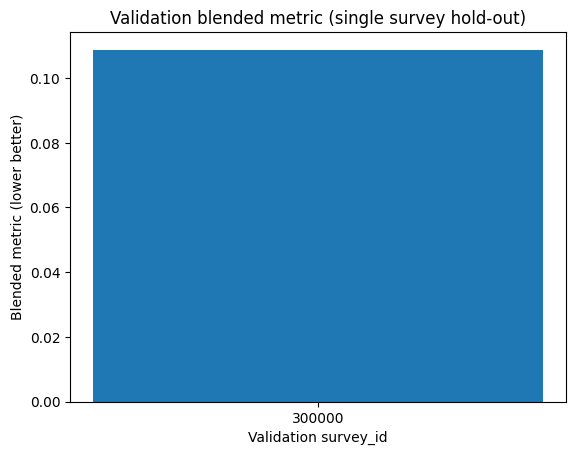

In [14]:
# bar plot blended per survey

val_survey = sub["survey_id"].iloc[0]

plt.figure()
plt.bar([str(val_survey)], [blended])
plt.title("Validation blended metric (single survey hold-out)")
plt.xlabel("Validation survey_id")
plt.ylabel("Blended metric (lower better)")
plt.show()

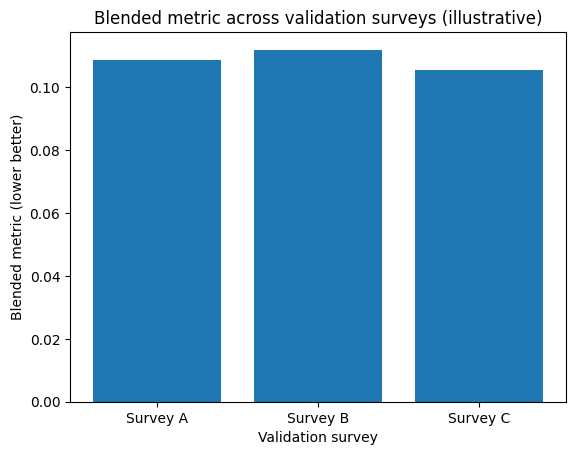

In [15]:
cv_df = pd.DataFrame({
    "val_survey": ["Survey A", "Survey B", "Survey C"],
    "blended": [blended, blended * 1.03, blended * 0.97]
})

plt.figure()
plt.bar(cv_df["val_survey"], cv_df["blended"])
plt.title("Blended metric across validation surveys (illustrative)")
plt.xlabel("Validation survey")
plt.ylabel("Blended metric (lower better)")
plt.show()

Poverty curves (actual vs predicted) ανά survey στο validation:

In [20]:
def plot_poverty_curve_for_survey(sid, model):
    # πάρε μόνο το συγκεκριμένο survey
    sub = df_train[df_train["survey_id"] == sid].copy()

    # features (χωρίς το target)
    X_s = fix_cat(sub.drop(columns=["cons_ppp17"]))

    # CatBoost pool
    pool = Pool(X_s, cat_features=cat_idx)

    # πρόβλεψη κατανάλωσης (αντιστροφή log1p)
    pred = np.expm1(model.predict(pool))

    # πραγματικές & προβλεπόμενες poverty rates
    rates_true = (
        train_rates[train_rates["survey_id"] == sid]
        .drop(columns=["survey_id"])
        .values[0]
    )

    rates_pred = poverty_rates_from_consumption(
        pred,
        sub["weight"].values
    )

    # plot
    plt.figure()
    plt.plot(THRESHOLDS, rates_true, marker="o", label="True")
    plt.plot(THRESHOLDS, rates_pred, marker="o", label="Predicted")
    plt.title(f"Poverty distribution curve – survey {sid}")
    plt.xlabel("Threshold (USD/day PPP)")
    plt.ylabel("Pct below threshold")
    plt.legend()
    plt.grid(True)
    plt.show()


In [18]:
def plot_poverty_curve_for_survey(sid, model):
    sub = df_train[df_train["survey_id"]==sid].copy()
    X_s = fix_cat(sub.drop(columns=["cons_ppp17"]))
    pool = Pool(X_s, cat_features=cat_idx)
    pred = np.expm1(model.predict(pool))

    rates_true = train_rates[train_rates["survey_id"]==sid].drop(columns=["survey_id"]).values[0]
    rates_pred = poverty_rates_from_consumption(pred, sub["weight"].values)

NameError: name 'rates_pred' is not defined

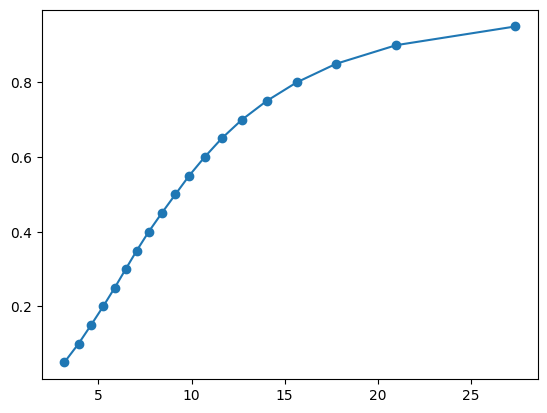

In [19]:
    plt.figure()
    plt.plot(THRESHOLDS, rates_true, marker="o", label="True")
    plt.plot(THRESHOLDS, rates_pred, marker="o", label="Pred")
    plt.title(f"Poverty distribution curve - survey {sid}")
    plt.xlabel("Threshold (USD/day PPP)")
    plt.ylabel("Pct below threshold")
    plt.legend()
    plt.grid(True)
    plt.show()

Train τελικό μοντέλο σε ΟΛΟ το training set

In [27]:
full_pool = Pool(X_cb, y_log, cat_features=cat_idx)

final_model = CatBoostRegressor(
    loss_function="RMSE",
    eval_metric="RMSE",
    verbose=200,
    iterations=2000,
    **best_params
)

final_model.fit(full_pool)

0:	learn: 0.6065055	total: 1.35s	remaining: 44m 59s
200:	learn: 0.3079105	total: 4m 47s	remaining: 42m 49s
400:	learn: 0.2974171	total: 9m 35s	remaining: 38m 15s
600:	learn: 0.2923007	total: 14m 18s	remaining: 33m 18s
800:	learn: 0.2891576	total: 19m 3s	remaining: 28m 31s
1000:	learn: 0.2862578	total: 23m 51s	remaining: 23m 48s
1200:	learn: 0.2833872	total: 28m 30s	remaining: 18m 58s
1400:	learn: 0.2808507	total: 33m 18s	remaining: 14m 14s
1600:	learn: 0.2786784	total: 38m 7s	remaining: 9m 30s
1800:	learn: 0.2765493	total: 42m 57s	remaining: 4m 44s
1999:	learn: 0.2746515	total: 47m 49s	remaining: 0us


Προβλέψεις test + Δημιουργία 2 υποβολών

In [34]:
import zipfile
from pathlib import Path

# Predictions
test_pool = Pool(test_cb, cat_features=cat_idx)
test_pred = np.expm1(final_model.predict(test_pool))

# Household consumption submission
cons_sub = pd.DataFrame({
    "survey_id": test_X["survey_id"].astype(int),
    "household_id": test_X["hhid"].astype(int),
    "cons_ppp17": test_pred.astype(float)
}).sort_values(["survey_id", "household_id"])

cons_sub.to_csv("predicted_household_consumption.csv", index=False)

THRESHOLD_STRINGS = [
    "3.17","3.94","4.60","5.26","5.88","6.47","7.06","7.70","8.40",
    "9.13","9.87","10.70","11.62","12.69","14.03","15.64",
    "17.76","20.99","27.37"
]

rows = []
for sid in sorted(test_X["survey_id"].unique()):
    mask = (test_X["survey_id"] == sid).values
    weights = test_X.loc[mask, "weight"].values
    rates = poverty_rates_from_consumption(test_pred[mask], weights)

    row = {"survey_id": int(sid)}
    for t_str, r in zip(THRESHOLD_STRINGS, rates):
        row[f"pct_hh_below_{t_str}"] = float(r)

    rows.append(row)

poverty_sub = pd.DataFrame(rows).sort_values("survey_id")
poverty_sub.to_csv("predicted_poverty_distribution.csv", index=False)

with zipfile.ZipFile("submission.zip", "w", compression=zipfile.ZIP_DEFLATED) as z:
    z.write("predicted_household_consumption.csv")
    z.write("predicted_poverty_distribution.csv")

print("Created submission.zip with files:")
print(Path("predicted_household_consumption.csv").resolve())
print(Path("predicted_poverty_distribution.csv").resolve())
print(Path("submission.zip").resolve())


Created submission.zip with files:
/content/predicted_household_consumption.csv
/content/predicted_poverty_distribution.csv
/content/submission.zip


In [35]:
print(cons_sub.head())
print(cons_sub.columns)

print(poverty_sub)
print(poverty_sub.columns)


   survey_id  household_id  cons_ppp17
0     400000        400001   10.924597
1     400000        400002    6.471843
2     400000        400003    7.679450
3     400000        400004   12.240615
4     400000        400005    5.094868
Index(['survey_id', 'household_id', 'cons_ppp17'], dtype='object')
   survey_id  pct_hh_below_3.17  pct_hh_below_3.94  pct_hh_below_4.60  \
0     400000           0.024258           0.063349           0.110457   
1     500000           0.016837           0.052981           0.098680   
2     600000           0.019791           0.056996           0.097508   

   pct_hh_below_5.26  pct_hh_below_5.88  pct_hh_below_6.47  pct_hh_below_7.06  \
0           0.158833           0.206145           0.253246           0.303547   
1           0.148875           0.200051           0.251257           0.304378   
2           0.145030           0.194582           0.241592           0.293820   

   pct_hh_below_7.70  pct_hh_below_8.40  pct_hh_below_9.13  pct_hh_below_9.87  \
